# AirBNB data exploration

In this notebook, we're going to try to answer the following questions:

- What is affecting price variations?
- Does it cares that a host has several listings on price variations?
- When is a property on high or low price? (predictable)

In [14]:
# Required imports for the project
import pandas as pd
import numpy as np
import seaborn as sns
import swifter
import dask.dataframe as dd


from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
import matplotlib

#Custom function to download datasets from airbnb site.
from utils import download_datasets

In [47]:
#datasets to download
datasets_urls_boston = [
    'http://data.insideairbnb.com/united-states/ma/boston/2018-08-17/data/listings.csv.gz',
    'http://data.insideairbnb.com/united-states/ma/boston/2018-08-17/data/calendar.csv.gz',
    'http://data.insideairbnb.com/united-states/ma/boston/2018-09-14/data/reviews.csv.gz'
]

datasets_urls_seattle = [
    'http://data.insideairbnb.com/united-states/wa/seattle/2018-08-16/data/listings.csv.gz',
    'http://data.insideairbnb.com/united-states/wa/seattle/2018-08-16/data/calendar.csv.gz',
    'http://data.insideairbnb.com/united-states/wa/seattle/2018-09-14/data/reviews.csv.gz'
]
datasets_urls_austin = [
    'http://data.insideairbnb.com/united-states/tx/austin/2018-08-14/data/listings.csv.gz',
    'http://data.insideairbnb.com/united-states/tx/austin/2018-08-14/data/calendar.csv.gz'
]


datasets_urls_losangeles = [
    'http://data.insideairbnb.com/united-states/ca/los-angeles/2018-09-08/data/listings.csv.gz',
    'http://data.insideairbnb.com/united-states/ca/los-angeles/2018-09-08/data/calendar.csv.gz'
]

datasets_urls_neworleans = [
    'http://data.insideairbnb.com/united-states/la/new-orleans/2018-09-08/data/listings.csv.gz',
    'http://data.insideairbnb.com/united-states/la/new-orleans/2018-09-08/data/calendar.csv.gz'
]


datasets_urls_sandiego = [
    'http://data.insideairbnb.com/united-states/ca/san-diego/2018-09-13/data/listings.csv.gz',
    'http://data.insideairbnb.com/united-states/ca/san-diego/2018-09-13/data/calendar.csv.gz'
]

download_datasets(datasets_urls_boston, 'boston_')
download_datasets(datasets_urls_seattle, 'seattle_')
download_datasets(datasets_urls_austin, 'austin_')
download_datasets(datasets_urls_losangeles, 'losangeles_')
download_datasets(datasets_urls_neworleans, 'neworleans_')
download_datasets(datasets_urls_sandiego, 'sandiego_')

datasets_cities = [
    'boston',
    'seattle',
    'austin',
    'neworleans',
    'sandiego',
]

File: boston_listings.csv.gz, in cache
File: boston_calendar.csv.gz, in cache
File: seattle_listings.csv.gz, in cache
File: seattle_calendar.csv.gz, in cache
File: austin_listings.csv.gz, in cache
File: austin_calendar.csv.gz, in cache
File: losangeles_listings.csv.gz, in cache
File: losangeles_calendar.csv.gz, in cache
File: neworleans_listings.csv.gz, in cache
File: neworleans_calendar.csv.gz, in cache
File: sandiego_listings.csv.gz, in cache
File: sandiego_calendar.csv.gz, in cache


In [ ]:
#Reading files and loading data into Dataframe

listings = []
calendar = []

for city in datasets_cities:
    listings += [pd.read_csv(city+'_listings.csv.gz', index_col=0, low_memory=False)]
    calendar += [pd.read_csv(city+'_calendar.csv.gz', parse_dates=['date'], low_memory=False)]

listings = pd.concat(listings)
calendar = pd.concat(calendar)

In [16]:
def load_dataframes(datasets):
    df_calendars = {}
    df_listings = {}
    for city in datasets:
        df_listings[city] = pd.read_csv(city+'_listings.csv.gz', index_col=0, low_memory=False)
        df_calendars[city] = pd.read_csv(city+'_calendar.csv.gz', parse_dates=['date'], low_memory=False)
    
    return df_calendars, df_listings

In [17]:
# Data cleanning

def cleaning_calendar(df):
    #transform 't' or 'f' into True or False values.
    df.available = df.available.apply(lambda x: x == "t")
    #remove $ sign and parse the value as numeric.
    df.price = df.price.apply(lambda x: float(str(x).replace("$","").replace(",","")))
    df.reset_index(drop=True)
    return df



In [ ]:
calendar = cleaning_calendar(calendar)

In [ ]:
calendar['price'].describe()

In [ ]:
calendar.groupby('listing_id').count().mean()

Data per listing is related to a entire year

In [ ]:
%%time
def date_to_cols(df):
    df = df.copy()
    df['year'] = 0
    df['month'] = 0
    df['day'] = 0
    def date_to_cols_apply(x):
        x = x.copy()
        x.year = x.date.year
        x.month = x.date.month
        x.day = x.date.day
        return x
    return df.swifter.apply(date_to_cols_apply, axis=1)

In [ ]:
calendar = date_to_cols(calendar)

In [ ]:
#calendar = calendar.drop(['date'], axis=1)
stats_calendar = calendar.price.describe()

In [ ]:
calendar['price_per_listing'] = 0.0
calendar = calendar.fillna(0)

def apply_per_listing(df):
    df.price_per_listing = MinMaxScaler().fit_transform(df.price.values.reshape(-1, 1))
    return df

In [ ]:
ddf = dd.from_pandas(calendar, npartitions=6)

In [ ]:
%%time
calendar = ddf.groupby('listing_id').apply(apply_per_listing, meta=ddf).compute()

In [5]:
def generate_price_per_listing(df):
    df['price_per_listing'] = 0.0
    df = df.fillna(0)

    def apply_per_listing(df):
        df.price_per_listing = MinMaxScaler().fit_transform(df.price.values.reshape(-1, 1))
        return df
    ddf = dd.from_pandas(df, npartitions=6)
    df = ddf.groupby('listing_id').apply(apply_per_listing, meta=ddf).compute()
    return df

In [ ]:
p25_50 = calendar[calendar.price <= stats_calendar['50%']][calendar.price > stats_calendar['25%']][calendar.available].groupby(["month"]).price_per_listing.mean()
p50_75 = calendar[calendar.price <= stats_calendar['75%']][calendar.price > stats_calendar['50%']][calendar.available].groupby(["month"]).price_per_listing.mean()
p25 = calendar[calendar.price <= stats_calendar['25%']][calendar.available].groupby(["month"]).price_per_listing.mean()
p75 = calendar[calendar.price > stats_calendar['75%']][calendar.available].groupby(["month"]).price_per_listing.mean()



res = pd.concat([p25, p25_50, p50_75, p75], axis=1)
res.columns = ['0-25', 'p25_50', 'p50_75','75-100']


res
fig, ax = plt.subplots()

plt.grid(True)
fig.set_size_inches(11.7, 8.27)


sns.lineplot(data=res).set_title("Month vs Avg.Price per quartile");

In [ ]:
p25_50 = calendar[calendar.price <= stats_calendar['50%']][calendar.price > stats_calendar['25%']].groupby(["month"]).available.sum()
p50_75 = calendar[calendar.price <= stats_calendar['75%']][calendar.price > stats_calendar['50%']].groupby(["month"]).available.sum()
p25 = calendar[calendar.price <= stats_calendar['25%']].groupby(["month"]).available.sum()
p75 = calendar[calendar.price > stats_calendar['75%']].groupby(["month"]).available.sum()



res = pd.concat([p25, p25_50, p50_75,  p75], axis=1)
res.columns = ['0-25', 'p25_50', 'p50_75','75-100']

In [ ]:
fig, ax = plt.subplots()
plt.grid(True)
fig.set_size_inches(11.7, 8.27)


sns.lineplot(data=res).set_title("Month vs Availability(sum) per quartile");

In [18]:
def getting_quartiles(df):
    
    stats_calendar = df.price.describe()
    
    p75_price = df[df.price > stats_calendar['75%']][df.available].groupby(df.date.dt.month).price_per_listing.mean()
    #p50_75_price = df[df.price <= stats_calendar['75%']][df.price > stats_calendar['50%']][df.available].groupby(df.date.dt.month).price_per_listing.mean()
    #p25_50_price = df[df.price <= stats_calendar['50%']][df.price > stats_calendar['25%']][df.available].groupby(df.date.dt.month).price_per_listing.mean()
    #p25_price = df[df.price <= stats_calendar['25%']][df.available].groupby(df.date.dt.month).price_per_listing.mean()

    p75_av = df[df.price > stats_calendar['75%']].groupby(df.date.dt.month).available.sum()
    #p50_75_av = df[df.price <= stats_calendar['75%']][df.price > stats_calendar['50%']].groupby(df.date.dt.month).available.sum()
    #p25_50_av = df[df.price <= stats_calendar['50%']][df.price > stats_calendar['25%']].groupby(df.date.dt.month).available.sum()
    #p25_av = df[df.price <= stats_calendar['25%']].groupby(df.date.dt.month).available.sum()

    
    #return p75_price, p50_75_price, p25_50_price, p25_price, p75_av, p50_75_av, p25_50_av, p25_av
    return p75_price, p75_av
    
def plot_quartile(price, availability, label):

    scaler = MinMaxScaler()
    scaler.fit([[availability.min()], [availability.max()]])
    availability = availability.apply(lambda x: scaler.transform([[x]])[0][0])

    res = pd.concat([availability, price], axis=1)
    res.columns = [label+'_av', label+'_pr']
    fig, ax = plt.subplots()
    plt.grid(True)
    fig.set_size_inches(11.7, 8.27)
    sns.lineplot(data=res).set_title("Price and Availability by month within quartile " + label);


In [48]:
df_calendars, _ = load_dataframes(datasets_cities)

In [49]:
for key in df_calendars.keys():
    df_calendars[key] = cleaning_calendar(df_calendars[key])
    df_calendars[key] = generate_price_per_listing(df_calendars[key])

In [50]:
def p75_availabity(dfs):
    p75 = []
    for k, v in dfs.items():
        stats_calendar = v.price.describe()
        p75_av = v[v.price > stats_calendar['75%']].groupby(v.date.dt.month).available.sum()
        p75_av = df[df.price > stats_calendar['75%']].groupby(df.date.dt.month).available.sum()
        p50_75_av = df[df.price <= stats_calendar['75%']][df.price > stats_calendar['50%']].groupby(df.date.dt.month).available.sum()
        p25_50_av = df[df.price <= stats_calendar['50%']][df.price > stats_calendar['25%']].groupby(df.date.dt.month).available.sum()
        p25_av = df[df.price <= stats_calendar['25%']].groupby(df.date.dt.month).available.sum()
        scaler = MinMaxScaler()
        scaler.fit([[p75_av.min()], [p75_av.max()]])
        p75_av = p75_av.apply(lambda x: scaler.transform([[x]])[0][0])
        p75_av.name = k
        p75.append(p75_av)
    p75 = pd.DataFrame(p75).T
    return p75

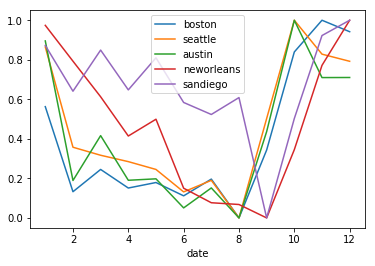

In [53]:
p75_availabity(df_calendars).plot()

In [54]:
def p75_pricing(dfs):
    p75 = []
    for k, v in dfs.items():
        stats_calendar = v.price.describe()
        p75_price = v[v.price > stats_calendar['75%']].groupby(v.date.dt.month).price_per_listing.mean()
        p75_price.name = k
        p75.append(p75_price)
    p75 = pd.DataFrame(p75).T
    return p75

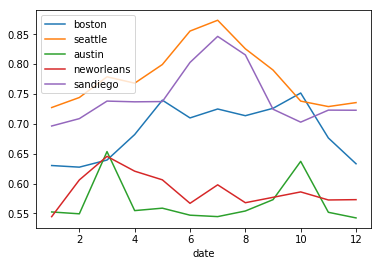

In [57]:
p75_pricing(df_calendars).plot()